In [1]:
import numpy as np 
import pyaudio as pa 
import struct 
import matplotlib.pyplot as plt 
import serial
import time
import sys
import pandas as pd 

from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume

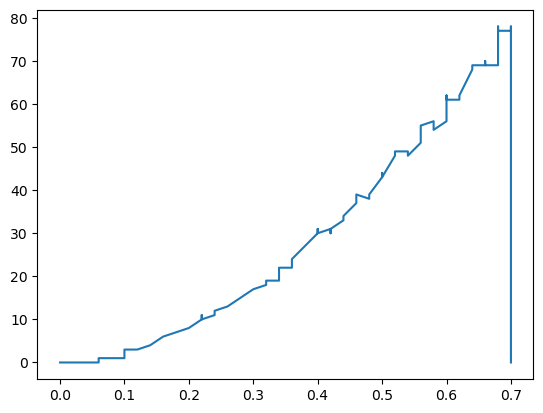

In [2]:
CHUNK = 1024 * 2     # How many samples are we reading per time to analyze
FORMAT = pa.paInt16  # pyaudio format, 16 bit depth is more than enough here
CHANNELS = 1         # Since we only want one cool looking plot anyway, this suffices
RATE = 48000         # sample rate in Hz of incoming audio (44100 is default on my windows pc, but the stereo player does 48000, which is higher. And bigger=better no?)
INDEX = 1            # Device index used as input for stream, if the stereo device is enabled it should be at 1
scale = 1            # plot scaling
verbose=False         # Nerd stats

# Open pyaduio object
p = pa.PyAudio()

# Print some information for inspection
if verbose:
	for i in range(p.get_device_count()):
		print(p.get_device_info_by_index(i))
	print("###################")
	print(p.get_default_input_device_info())
	print("###################")
	print(p.get_default_output_device_info())

	print("Opening stream object at\nFormat: {FORMAT}\nChannels: {CHANNELS}\nRate: {RATE}\nframes_per_buffer: {CHUNK}\ninput_device_index: {INDEX}")

# Open pyaudio.stream object
stream = p.open(
	format = FORMAT,
	channels = CHANNELS,
	rate = RATE,
	input=True,
	output=True,
	frames_per_buffer=CHUNK,
	input_device_index=INDEX
)


vol=5000

data=b'0'

devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(
	IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))

# Get the current volume level


sys_vols  = np.zeros(500)
vols      = np.zeros(500)
i = 0
while i<500:
	# Reading and unpacking data
	#print(f"{int.from_bytes(data,'little')}:{vol}")
	data = stream.read(CHUNK)
	dataInt = struct.unpack(str(CHUNK) + 'h', data) # h indicates the short type, a 2 byte (16 bit) signed integer. So from -32767 to 32767 (hence the ylims above)
	vol=np.max(dataInt)
	vol=int((vol/32767)*255)
	sys_vol = volume.GetMasterVolumeLevelScalar()
	print(f"{vol} and {sys_vol:.3f} and {i}   ",end='\r')
	sys_vols[i]=sys_vol
	vols[i]    =vol
	i+=1

plt.plot(sys_vols,vols)

In [13]:
sys_vols_n = sys_vols[:-100]
vols_n = vols[:-100]
import scipy


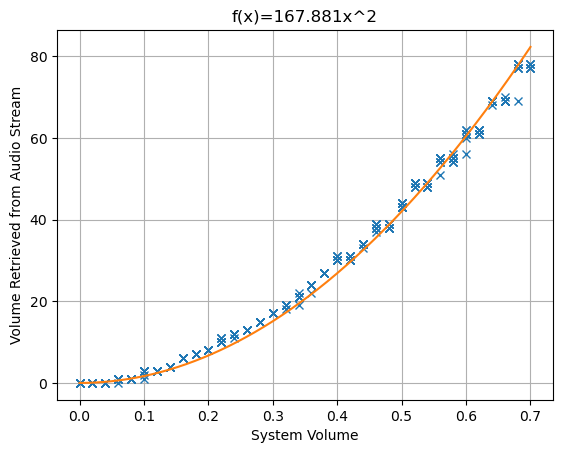

In [20]:
def squared(x,a):
	return a*x**2

val, cov = scipy.optimize.curve_fit(squared,sys_vols_n,vols_n)

x = np.linspace(0,0.7,1000)

plt.plot(sys_vols_n,vols_n,ls='',marker='x')
plt.plot(x,squared(x,val[0]))
plt.title(f"f(x)={val[0]:.3f}x^2")
plt.xlabel("System Volume")
plt.ylabel("Volume Retrieved from Audio Stream")
plt.grid()

plt.savefig("Sys_volume_to_volume.png")